# k-Nearest Neighbors

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#Carico i dati
df = pd.read_csv('..\\data\\data.csv')

#Definisco feature e target
features = ['wind_direction', 'U', 'concentration', 'q']
target = 'distance'
X = df[features]
y = df[target]

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split dei dati
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Informazioni sui dati
print("Shape of the dataset:", df.shape)
print("Classi target:", sorted(y.unique()))
print('Distribution of target classes:', y.value_counts().sort_index())


Shape of the dataset: (2836, 7)
Classi target: [np.int64(50), np.int64(100), np.int64(200)]
Distribution of target classes: distance
50     1081
100     963
200     792
Name: count, dtype: int64


In [13]:

# Ricerca del miglior K con GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 21)}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=kf, scoring='accuracy')
grid.fit(X_train, y_train)
# Stampo il miglior parametro K
print(f'Miglior numero di vicini (K): {grid.best_params_["n_neighbors"]}')
print(f'Miglior score: {grid.best_score_:.4f}')


Miglior numero di vicini (K): 5
Miglior score: 0.5592


In [14]:

# Addestramento del modello con il miglior K
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
# Predizione sui dati di test
y_pred = knn.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

          50       0.71      0.68      0.69       351
         100       0.43      0.52      0.47       273
         200       0.61      0.50      0.55       227

    accuracy                           0.58       851
   macro avg       0.59      0.57      0.57       851
weighted avg       0.59      0.58      0.59       851

Confusion Matrix:
 [[239 103   9]
 [ 68 142  63]
 [ 30  83 114]]


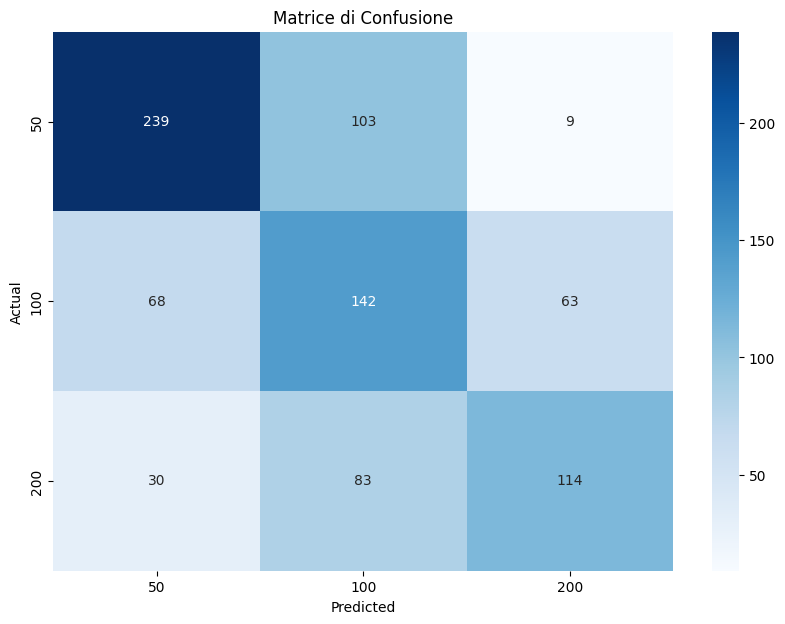

In [17]:

# Valutazione del modello
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Plot della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matrice di Confusione')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

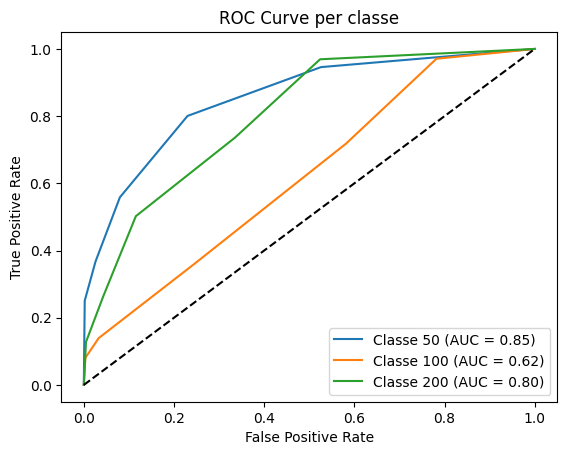

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = knn.predict_proba(X_test)

for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Classe {class_label} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per classe')
plt.legend()
plt.show()

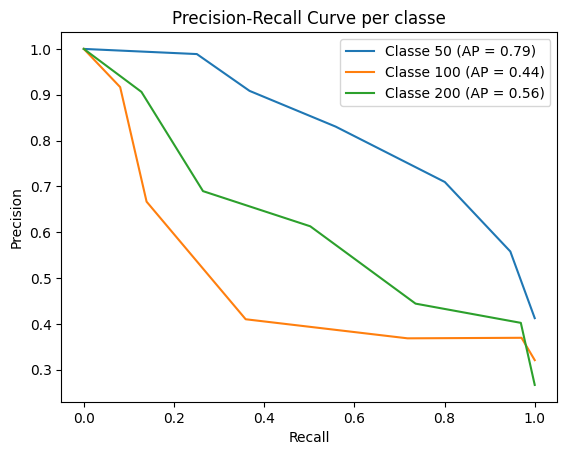

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Classe {class_label} (AP = {average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per classe')
plt.legend()
plt.show()

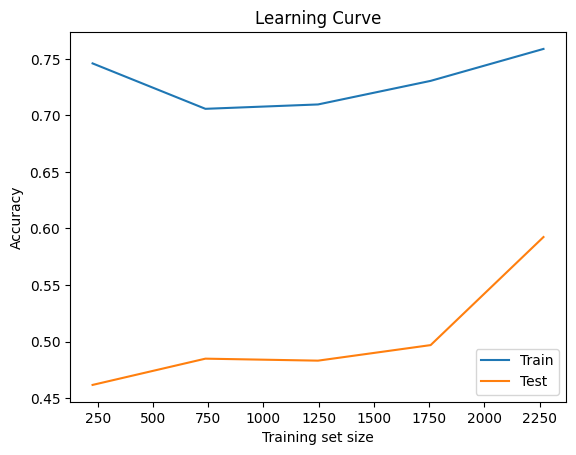

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(knn, X_scaled, y, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [8]:
import joblib
# salvo il modello
joblib.dump(knn, 'knn_model.pkl')


['knn_model.pkl']

### Risultati

I grafici e le metriche mostrano come questo modello abbia difficoltá a discriminare le classi, in particolare le classi 100, 200. Si evince quindi un problema di feature poco discriminate nel dataset per quelle due classi. Inoltre la learning curve mostra come il modello vada in overfitting, quindi impara troppo bene i dettagli (anche il rumore) dei dati di training e non riesce poi a generalizzare su dati nuovi.